# Class DE isoform only

In [1]:
import anndata
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.patches as mpatches
import scanpy as sc
from scipy.stats import ks_2samp, ttest_ind
import ast
from scipy.sparse import csr_matrix
import warnings
warnings.filterwarnings('ignore')

import sys
sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/dexpress')
from dexpress import dexpress, utils, plot

sys.path.append('/home/sina/projects/mop/BYVSTZP_2020/trackfig')
from trackfig.utils import get_notebook_name
from trackfig.trackfig import trackfig 

TRACKFIG = "/home/sina/projects/mop/BYVSTZP_2020/trackfig.txt"
NB = get_notebook_name()

fsize=20

plt.rcParams.update({'font.size': fsize})
%config InlineBackend.figure_format = 'retina'

In [2]:
cluster_cmap = {
"Astro": (0.38823529411764707, 0.4745098039215686,  0.2235294117647059 ),  # 637939,
"Endo" : (0.5490196078431373,  0.6352941176470588,  0.3215686274509804 ),  # 8ca252,
"SMC"  : (0.7098039215686275,  0.8117647058823529,  0.4196078431372549 ),  # b5cf6b,
"VLMC" : (0.807843137254902,   0.8588235294117647,  0.611764705882353  ),  # cedb9c,
"Low Quality" : (0,0,0),
"L2/3 IT" : (0.9921568627450981,  0.6823529411764706,  0.4196078431372549  ),  # fdae6b
"L5 PT" : (0.9921568627450981,  0.8156862745098039,  0.6352941176470588  ),  # fdd0a2
"L5 IT" : (0.5176470588235295,  0.23529411764705882, 0.2235294117647059 ),  # 843c39
"L5/6 NP": "#D43F3A",
"L6 CT" : (0.8392156862745098,  0.3803921568627451,  0.4196078431372549 ),  # d6616b
"L6 IT" : (0.9058823529411765,  0.5882352941176471,  0.611764705882353  ),  # e7969c
"L6b" : (1.0,                 0.4980392156862745,  0.054901960784313725),  # ff7f0e
"L6 IT Car3" : (1.0,                 0.7333333333333333,  0.47058823529411764 ),  # ffbb78
"Lamp5" : (0.19215686274509805, 0.5098039215686274,  0.7411764705882353  ),  # 3182bd # blues
"Sncg" : (0.4196078431372549,  0.6823529411764706,  0.8392156862745098  ),  # 6baed6
"Vip" : (0.6196078431372549,  0.792156862745098,   0.8823529411764706  ),  # 9ecae1
"Sst" : (0.7764705882352941,  0.8588235294117647,  0.9372549019607843  ),  # c6dbef
"Pvalb":(0.7372549019607844,  0.7411764705882353,  0.8627450980392157  ),  # bcbddc
}

In [3]:
gene = anndata.read_h5ad("../../data/notebook/revision/gene.h5ad")
isoform = anndata.read_h5ad("../../data/notebook/revision/isoform.h5ad")

In [4]:
isoform = isoform[:,isoform.var.sort_values("gene_id").index]
gene = gene[:,gene.var.sort_values("gene_id").index]

In [5]:
isoform = isoform[isoform.obs.eval("subclass_label != 'L5 IT'").values]
gene = gene[gene.obs.eval("subclass_label != 'L5 IT'").values]

In [8]:
print(isoform.shape)
print(gene.shape)

(4599, 69172)
(4599, 19190)


In [9]:
mask = np.logical_or(gene.obs.class_label == "Glutamatergic", gene.obs.class_label == "GABAergic")

c_gene = gene[mask]
c_isoform = isoform[mask]

In [10]:
%%time
mat           = c_gene.layers["log1p"].todense()
components    = c_gene.obs.cell_id.values
features      = c_gene.var.gene_name.values
assignments   = c_gene.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = utils.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_gene = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_gene["p_corr"][markers_gene.eval("p_corr == 0").values] = sys.float_info.min

12-Dec-20 17:27:21 - 1 of 2 assignments: GABAergic
12-Dec-20 17:27:22 - 2 of 2 assignments: Glutamatergic


CPU times: user 1.24 s, sys: 1.03 s, total: 2.27 s
Wall time: 2.26 s


In [11]:
%%time
mat         = c_isoform.layers["log1p"].todense() # expects dense matrix
components  = c_isoform.obs.cell_id.values
features    = c_isoform.var.transcript_name.values
assignments = c_isoform.obs.class_label.values

unique = np.unique(assignments)
nan_cutoff = 0.9 # of elements in cluster
corr_method = "bonferroni"


p_raw, stat, es, nfeat = dexpress.dexpress(mat, components, features, assignments, nan_cutoff=nan_cutoff)
p_corr = dexpress.correct_pval(p_raw, nfeat, corr_method)

s = stat

markers_isoform = dexpress.make_table(assignments, features, p_raw, p_corr, es)

# convert the 0 pvalues to the smallest possible float
markers_isoform["p_corr"][markers_isoform.eval("p_corr == 0").values] = sys.float_info.min

12-Dec-20 17:27:25 - 1 of 2 assignments: GABAergic
12-Dec-20 17:27:27 - 2 of 2 assignments: Glutamatergic


CPU times: user 3.14 s, sys: 2.96 s, total: 6.1 s
Wall time: 6.1 s


# Only care about differential isoforms

In [12]:
alpha = 0.01
markers_isoform = markers_isoform.query(f"p_corr < {alpha}")
markers_isoform.sort_values("es")

,index,name,p_raw,p_corr,es
31179,GABAergic,Aldoa-203_ENSMUST00000106348,0,2.22507e-308,-3.82687
9890,GABAergic,Rtn4-201_ENSMUST00000060992,0,2.22507e-308,-2.39897
22463,GABAergic,Olfm1-203_ENSMUST00000102879,0,2.22507e-308,-2.18349
4687,GABAergic,Ttc9b-201_ENSMUST00000008088,0,2.22507e-308,-2.16353
63651,GABAergic,Chn1os1-201_ENSMUST00000123613,0,2.22507e-308,-2.04036
...,...,...,...,...,...
30444,GABAergic,Slc6a1-201_ENSMUST00000032454,0,2.22507e-308,5.14669
111290,Glutamatergic,Neurod6-201_ENSMUST00000044767,0,2.22507e-308,5.1789
129698,Glutamatergic,Slc17a7-201_ENSMUST00000085374,0,2.22507e-308,5.21244
122897,Glutamatergic,Nrgn-201_ENSMUST00000065668,0,2.22507e-308,5.34571


In [17]:
specific_isoform = "Gad1-206_ENSMUST00000140478"
gene.var[gene.var.gene_name.str.contains(f"{specific_isoform.split('-')[0]}")]

,transcript_id,gene_id,gene_name,transcript_name,length,txn_list,num_isoforms,gene_counts,dispersion,pass_disp_filter,highly_variable,means,dispersions,dispersions_norm
Gad1_ENSMUSG00000070880,ENSMUST00000130618,ENSMUSG00000070880,Gad1_ENSMUSG00000070880,Gad1-204_ENSMUST00000130618,398,"['ENSMUST00000130618', 'ENSMUST00000094934', '...",5,1751.232788,1.851743,True,True,5.725841,7.163288,4.293365
Gad1os_ENSMUSG00000087264,ENSMUST00000151851,ENSMUSG00000087264,Gad1os_ENSMUSG00000087264,Gad1os-201_ENSMUST00000151851,889,['ENSMUST00000151851'],1,1.795561,0.040926,True,True,0.291329,3.907286,0.962012


In [18]:
specific_gene = "Gad1_ENSMUSG00000070880"

In [19]:
specific_cluster = "GABAergic"

In [20]:
def violinplot(data, ax, **kwd): 
    xticklabels = kwd.get("xticklabels", [])
    xticks = kwd.get("xticks", [])
    selected = kwd.get("selected", None)
    color = kwd.get("color", "grey")
    
    if  len(xticks)==0: xticks = np.arange(len(data))+1;
    if  len(xticklabels)==0: xticklabels = np.arange(len(data))+1;
    assert(len(xticks) == len(xticklabels))
        
    violins = ax.violinplot(data, positions=xticks, showmeans=False, showmedians=False, showextrema=False)
    
    for vidx, v in enumerate(violins['bodies']):
        v.set_facecolor(color)
        v.set_edgecolor('black')
        v.set_alpha(1)
        if selected == vidx:
            v.set_facecolor("#D43F3A")

            
    
    for didx, d in enumerate(data):
        x = xticks[didx]
        xx = np.random.normal(x, 0.04, size=len(d))
        
        # actual points
        ax.scatter(xx, d, s = 5, color="white", edgecolor="black", linewidth=1)
        
        # mean and error bars
        mean = np.mean(d)
        stdev = np.sqrt(np.var(d))
        ax.scatter(x, mean, color="lightgrey", edgecolor="black", linewidth=1, zorder=10)    
        ax.vlines(x, mean - stdev, mean+stdev, color='lightgrey', linestyle='-', lw=2, zorder=9)
        
    ax.set(**{"xticks": xticks, "xticklabels":xticklabels})
    
    return ax


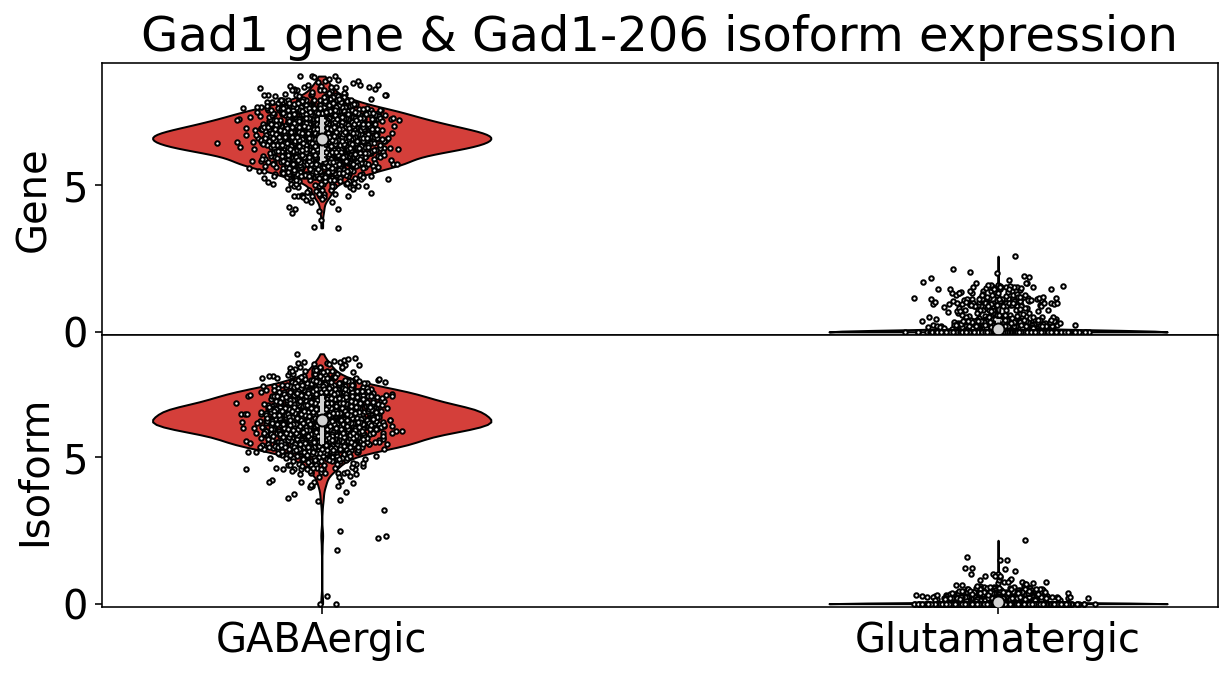

In [21]:
fig, ax = plt.subplots(figsize=(10,5), nrows=2, sharex=True)
fig.subplots_adjust(hspace=0, wspace=0)

# Declare
unique = np.unique(gene.obs.class_label)
unique = np.delete(unique, np.where(unique=="Low Quality"))
unique = np.delete(unique, np.where(unique=="Non-Neuronal"))
labels = unique
lidx = np.arange(1, len(labels)+1)  # the label locations
midx = np.where(unique==specific_cluster)[0][0]

## Plot
# Gene
x = []
for c in unique:
    x.append(np.asarray(gene[gene.obs.class_label==c][:,gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[0], selected=midx, xticks=lidx, xticklabels=labels)

# Isoform
x = []
for c in unique:
    x.append(np.asarray(isoform[isoform.obs.class_label==c][:,isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1).tolist())

violinplot(x, ax[1], selected=midx, xticks=lidx, xticklabels=labels)

ax[0].set(**{
    "title":"{} gene & {} isoform expression".format(specific_gene.split("_")[0], specific_isoform.split("_")[0]),
    "ylabel":"Gene",
    "ylim": (-0.1)
})
ymin, ymax = ax[0].get_ylim()
ax[1].set(**{
    "ylabel":"Isoform",
    "ylim": (ymin, ymax),
})

plt.savefig(trackfig("../../figures/class_DE_isoform_only_violin_{}.png".format(specific_gene.split("_")[0]), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

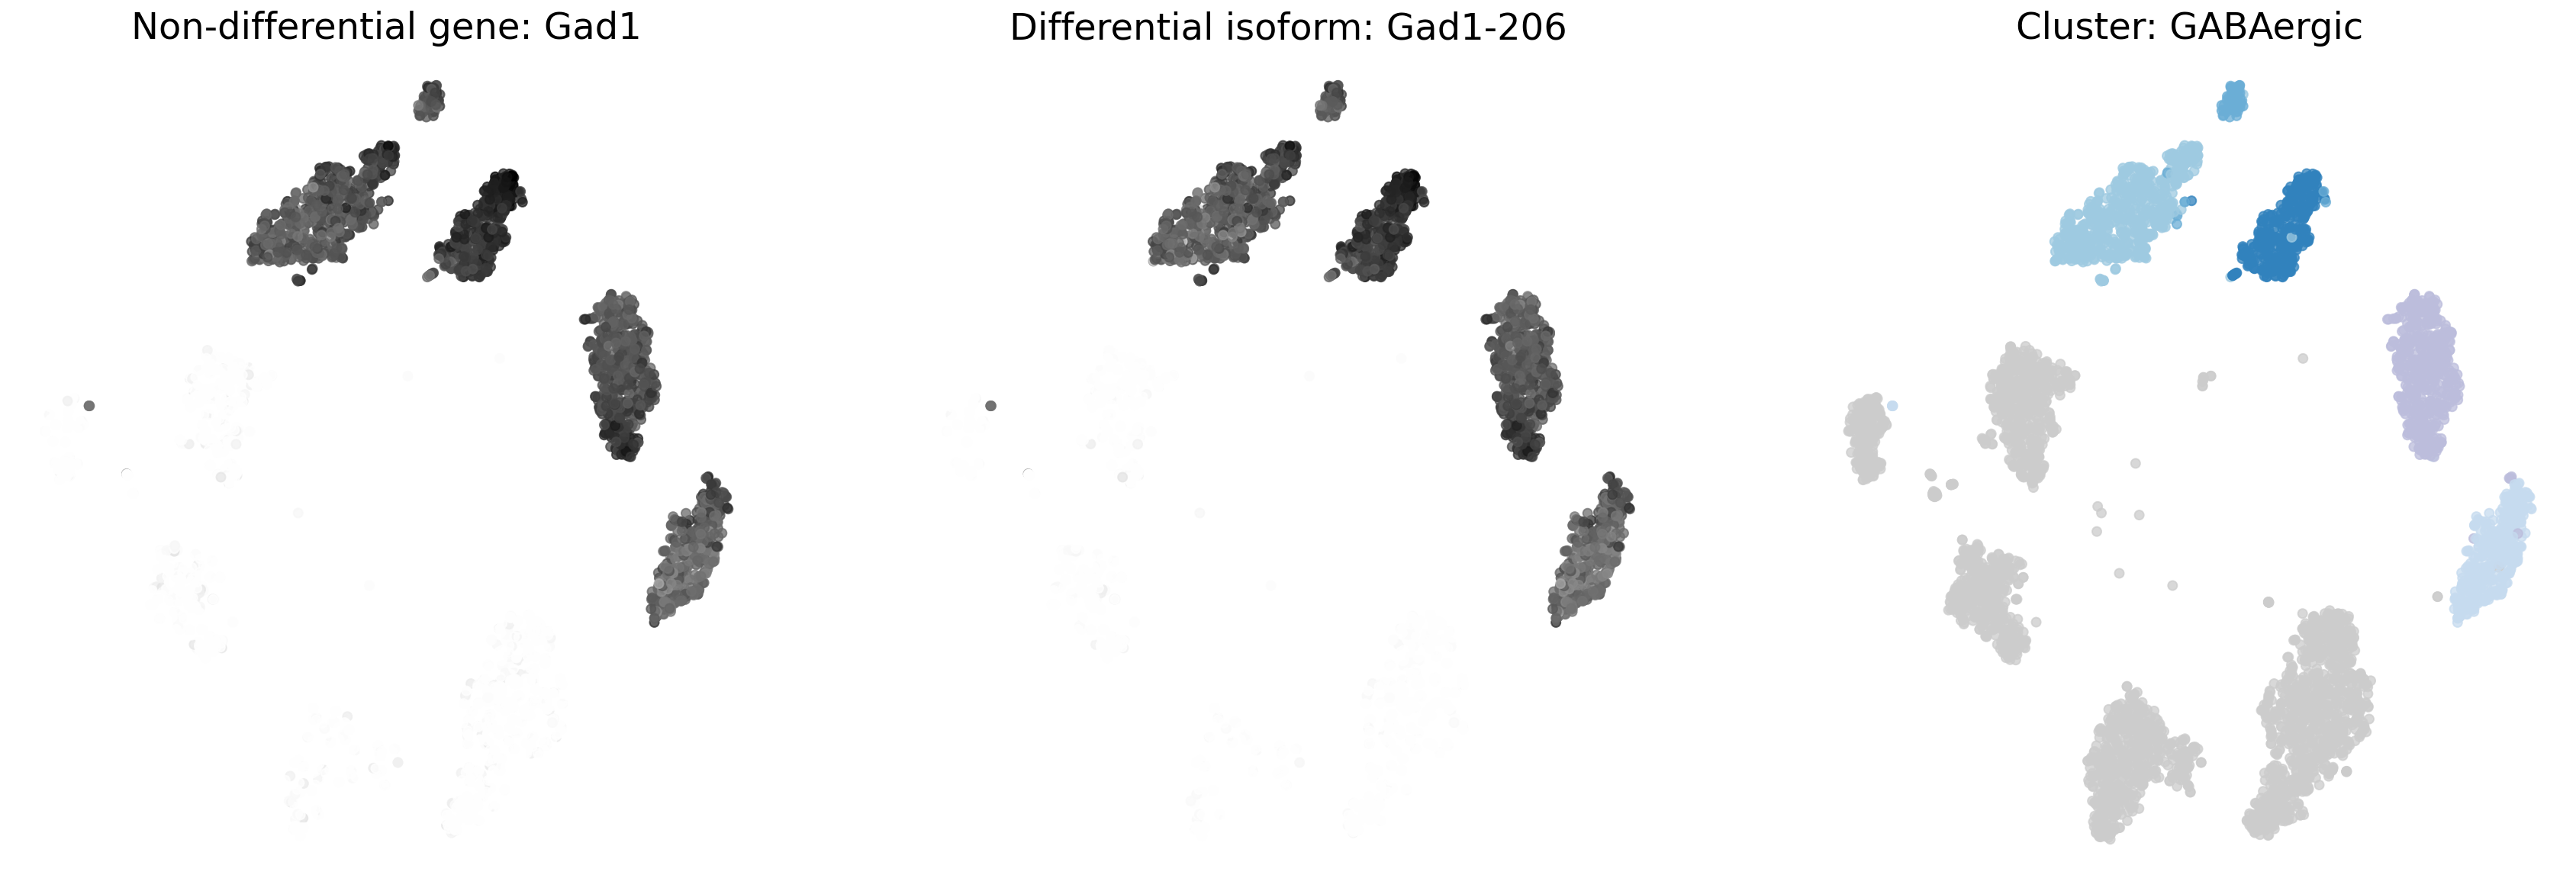

In [22]:
complement_color = (0.8, 0.8, 0.8, 1.0)

fig, ax = plt.subplots(figsize=(30,10), ncols=3)

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(gene[:, gene.var.gene_name==specific_gene].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[0].set_title("Non-differential gene: {}".format(specific_gene.split("_")[0]))

ax[0].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[0].set_axis_off()


x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = np.asarray(isoform[:, isoform.var.transcript_name==specific_isoform].layers["log1p"].todense()).reshape(-1)
cmap="Greys"
alpha = 0.75
ax[1].set_title("Differential isoform: {}".format(specific_isoform.split("_")[0]))

ax[1].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[1].set_axis_off()

x = gene.obsm["X_nca_tsne"][:,0]
y = gene.obsm["X_nca_tsne"][:,1]
c = gene.obs["subclass_label"]==specific_cluster
c = gene.obs["subclass_label"].astype(str).map(cluster_cmap).tolist()
indices = np.where(gene.obs["class_label"]!=specific_cluster)[0]
replacements=[complement_color]*len(indices)
for (index, replacement) in zip(indices, replacements):
    c[index] = replacement
alpha=0.75
cmap="nipy_spectral_r"

ax[2].scatter(x, y, c=c, cmap=cmap, alpha=alpha)
ax[2].set_axis_off()
ax[2].set_title("Cluster: {}".format(specific_cluster))
plt.savefig(trackfig("../../figures/class_DE_nca_{}.png".format(specific_gene.split("_")[0]), TRACKFIG, NB), bbox_inches='tight',dpi=300)
plt.show()

In [23]:
identified_isoforms = markers_isoform["name"].explode().astype(str)

In [24]:
identified_genes = identified_isoforms.apply(lambda x: x.split("-")[0:-1][0])

In [25]:
print("{} isoforms from {} genes identified.".format(identified_isoforms.shape[0], identified_genes.nunique()))

5658 isoforms from 3132 genes identified.


In [26]:
markers_isoform.to_csv(trackfig("../../tables/unordered/class_DE_isoform_only.csv", TRACKFIG, NB))

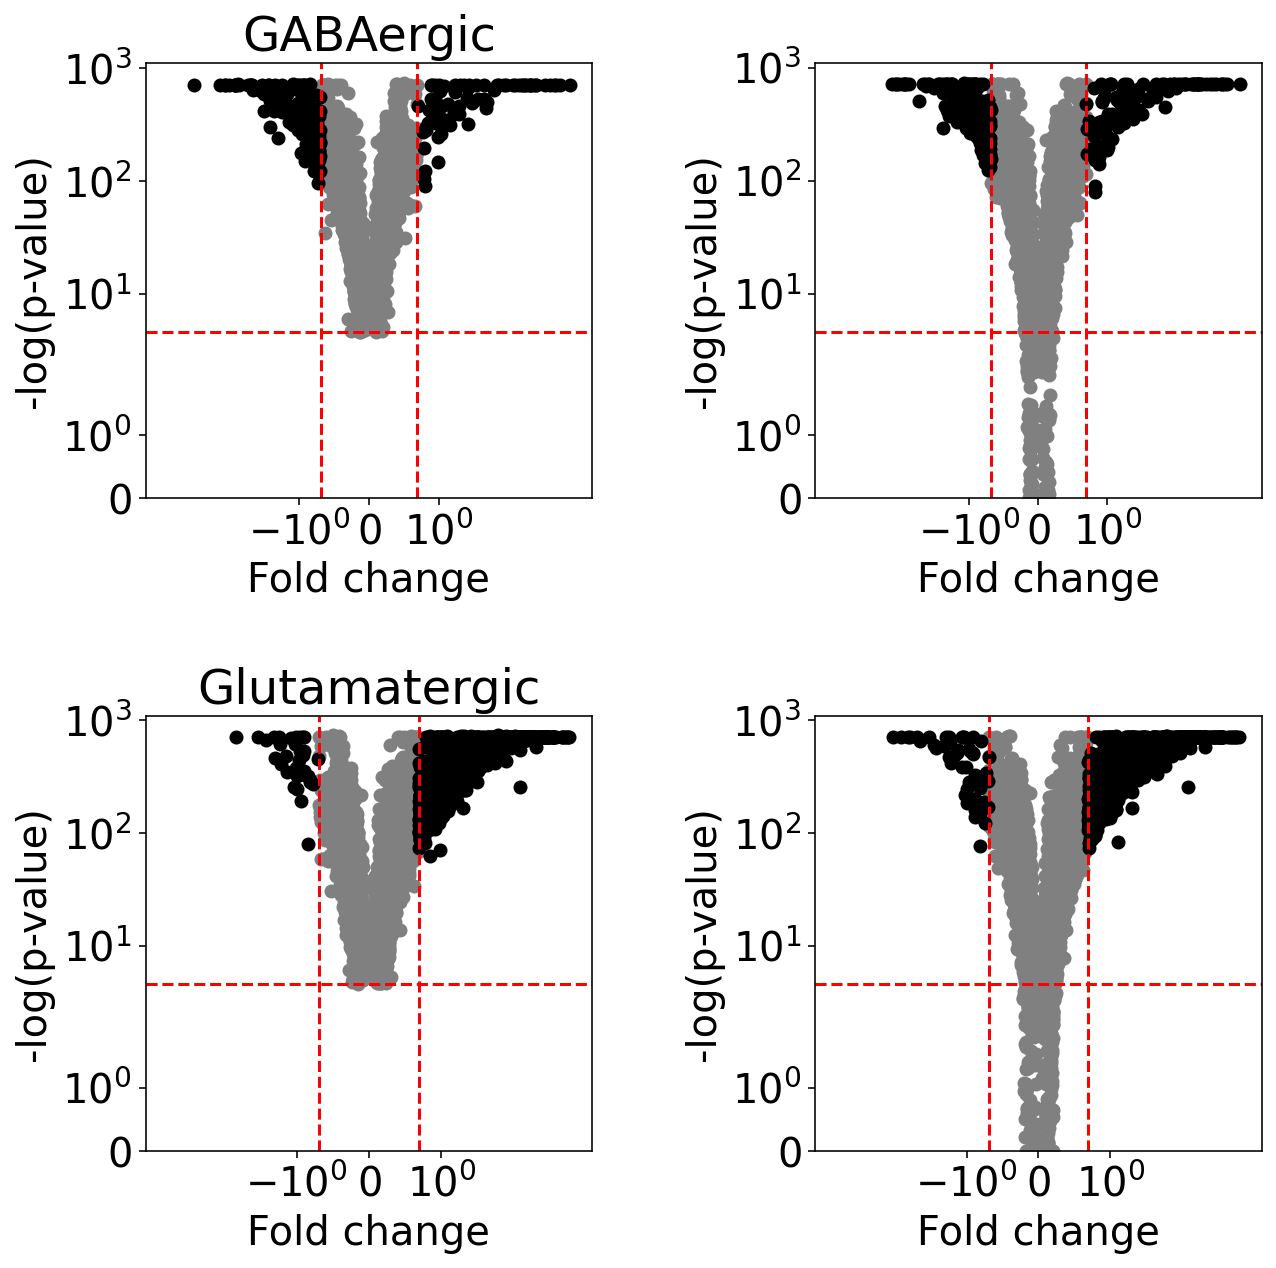

In [27]:
shape = 2
unique = np.unique(isoform.obs.class_label.values)

fig, axs = plt.subplots(figsize=(5*2, 5*shape), ncols=2, nrows=shape)
fig.subplots_adjust(hspace=0.5, wspace=0.5)


for idx, (ax, cluster) in enumerate(zip(axs, unique)):
    data = markers_isoform.query(f"index == '{cluster}'")

    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[0])
    ax[0].set_title(f"{cluster}")

    data = markers_gene.query(f"index == '{cluster}'")
    x = data["es"].values.astype(float)
    y = -np.log(data["p_corr"].values.astype(float))

    plot.volcano(x, y, ax[1])

fig.show()